# 3.1 Clustering analysis and PCA (on normalized fold change data)#

### IMPORTANT: Please make sure that you are using the R kernel to run this notebook.###
We are now switching from the bash kernel to the R kernel. 
The R language provides a number of utilities for genomic data analysis and visualization. We will explore some of these. 

In [15]:
#The preprocessCore library provides a number of functions useful for statistical analysis,
#including functions for data normalization that we will use below. 
library("preprocessCore")

In [ ]:
?library

In [16]:
#Change to your $WORK_DIR. The syntax for switching directories in R is a little different than what we used in bash. 
#Use the "setwd" command to switch to your $WORK_DIR 
sunetid="annashch"
work_dir=paste("/scratch/",sunetid,sep="")
setwd(work_dir)
#The "dir" command will list all files in your current working directory 
dir()

[1] "all_merged.peaks.bed"   "all.fc.bigwig"          "all.fc.txt"            
 [4] "all.peaks.bed"          "all.peaks.sorted.bed"   "all.readcount.txt"     
 [7] "all.tagAlign.files.txt" "cromwell_input.json"    "data"                  
[10] "narrowPeak_files.txt"   "old"                    "samples"               
[13] "src"                    "tmp"

In this tutorial we will focus on the clustering and PCA analysis steps of the pipeline: 
![Analysis pipeline](images/part3.png)

In [17]:
#load the fc signal matrix. You can either use the one you generated in the last tutorial,or the one that we have 
#pre-generated in the $AGGREGATE_ANALYSIS_DIR folder in case you ran into any issues with that step

#fc_data=read.table("all.fc.txt",header=TRUE)
fc_data=read.table("/outputs/all.fc.txt",header=TRUE)

rownames(fc_data)=paste(fc_data$Chrom,fc_data$Start,fc_data$End,sep='\t')
#remove the columns we will not use in downstream analysis
fc_data$ID=NULL
fc_data$Chrom=NULL
fc_data$Start=NULL
fc_data$End=NULL

head(fc_data)

,abalsubr_0min_YAP6_1,abalsubr_45min_HOT1_2,ajberg5_0min_HOG1_1,ajberg5_45min_WT_2,annashch_0min_SKO1_2,annashch_0min_YAP1_2,annashch_45min_YAP6_2,annlin_0min_MSN2_2,annlin_45min_YAP7_1,clin5_0min_MSN4_2,⋯,soumyak_0min_HOT1_2,soumyak_45min_YAP1_2,srstern_0min_WT_2,srstern_45min_MSN2_1,subkc_0min_MSN2_1,subkc_45min_YAP6_1,surag_0min_YAP7_2,surag_45min_HOT1_1,zahoor_0min_YAP6_2,zahoor_45min_YAP7_2
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chrI 13 555,4.957770,4.29057,5.66281,5.49536,3.684430,2.676360,5.18920,3.169010,6.25853,3.14240,⋯,2.166180,4.063620,4.189070,4.43075,4.739300,5.74437,4.342100,4.80380,4.03876,5.46832
chrI 6348 6518,1.290070,1.59601,2.79383,2.03220,1.244140,1.245420,1.56901,1.735560,1.70308,1.79756,⋯,1.853040,1.692480,1.930380,2.12778,1.526360,2.71398,1.769500,2.05286,1.99142,1.15365
chrI 9278 9407,0.901959,1.52957,1.07277,1.22491,0.681799,0.344013,1.19663,0.741686,1.29338,1.03387,⋯,0.435685,0.464266,0.623295,1.52466,0.699993,2.56766,0.401088,1.45043,1.05014,1.78285
chrI 20461 21185,2.210300,5.06794,3.16512,5.35651,2.170190,3.012710,4.37700,2.354330,6.04788,2.84044,⋯,2.890330,5.521270,3.126570,5.43662,2.344150,5.37308,2.434870,5.65024,2.82576,4.76127
chrI 28591 28910,2.409450,1.78411,1.83696,1.64104,2.714190,2.444450,2.30738,2.423330,1.64492,2.57691,⋯,1.757090,1.793510,2.188910,1.81232,1.427110,2.90140,1.911310,1.61681,2.53014,1.49883
chrI 29757 30083,2.577760,2.52926,2.69671,2.72851,2.767060,2.538610,2.97314,2.389030,3.25956,2.68235,⋯,2.205240,2.403670,2.493340,2.63770,2.378950,3.09649,2.326440,2.82477,2.96337,2.29648


In [18]:
#normalize the data 
#quantile normalization 
norm_asinh_fc=normalize.quantiles(data.matrix(asinh(fc_data)))

In [19]:
colnames(norm_asinh_fc)=names(fc_data)
rownames(norm_asinh_fc)=rownames(fc_data)

In [20]:
head(norm_asinh_fc)

,abalsubr_0min_YAP6_1,abalsubr_45min_HOT1_2,ajberg5_0min_HOG1_1,ajberg5_45min_WT_2,annashch_0min_SKO1_2,annashch_0min_YAP1_2,annashch_45min_YAP6_2,annlin_0min_MSN2_2,annlin_45min_YAP7_1,clin5_0min_MSN4_2,⋯,soumyak_0min_HOT1_2,soumyak_45min_YAP1_2,srstern_0min_WT_2,srstern_45min_MSN2_1,subkc_0min_MSN2_1,subkc_45min_YAP6_1,surag_0min_YAP7_2,surag_45min_HOT1_1,zahoor_0min_YAP6_2,zahoor_45min_YAP7_2
chrI 13 555,2.3358936,2.069507,2.426536,2.257144,2.2165978,1.9213219,2.2306836,2.0061094,2.294371,2.018193,⋯,1.5485338,2.0314401,2.2446227,2.031440,2.3037566,2.148855,2.2870096,2.0797749,2.1623475,2.2926307
chrI 6348 6518,1.2372242,1.183692,1.828742,1.398641,1.2294140,1.0816721,1.1881672,1.3437882,1.229844,1.313834,⋯,1.3782175,1.2074647,1.4528809,1.330018,1.3355791,1.533231,1.4266048,1.3316256,1.4570309,0.9758037
chrI 9278 9407,0.9862243,1.149393,1.034905,1.000761,0.8641299,0.3302547,0.9359348,0.6705444,1.006694,0.829496,⋯,0.3878696,0.3565664,0.5038154,1.005797,0.7550395,1.490473,0.3302547,0.9972218,0.9001616,1.3170861
chrI 20461 21185,1.6928130,2.233738,1.924171,2.232350,1.7073344,2.0777233,2.0642480,1.6673718,2.260716,1.884909,⋯,1.9180377,2.3475029,1.9542330,2.260716,1.7125973,2.086184,1.7333204,2.2430285,1.8122675,2.1488547
chrI 28591 28910,1.7614866,1.275467,1.463753,1.219591,1.9227076,1.7970714,1.5148544,1.6962385,1.201388,1.733320,⋯,1.3331333,1.2545968,1.5747007,1.177964,1.2805313,1.582116,1.4994731,1.0983180,1.7018816,1.1828030
chrI 29757 30083,1.8127411,1.581788,1.794476,1.632903,1.9444076,1.8479562,1.7361543,1.6800086,1.730530,1.799029,⋯,1.5662711,1.5343967,1.7094876,1.535205,1.7240301,1.635369,1.6883561,1.6111434,1.8565548,1.5130505


Much better! After quantile normalization, the fold change values across samples are on the same scale. 

## PCA ##

PCA (Principal Component Analysis) is a way to identify the primary directions of variation in the data. It can also be used for very coarse-grained clustering of samples; similar samples will have similar coordinates along the principal axes.

We will perform PCA on *all.fc.txt*. We treat each sample as a single point in a very high dimensional space (where the dimensionality is equal to the number of genes the vary), and then we will perform dimensionality reduction in this space. We can color-code the PCA plots by "Strain", "Timepoint", "Researcher", or "Rep" to determine which parameter separates the samples most effectively. 

In [21]:
#We run the principle component analysis command in R

#The t() function transposes the data matrix and allows us to cluster the samples, as opposed to the individual peaks,
#by placing the samples in the rows and the peaks in the columns. 
fc.pca=prcomp(t(norm_asinh_fc),center=TRUE,scale=FALSE)

We generate a scree plot that shows how much variance in the data is explained by each prinicipal component:

In [22]:
var_explained=round(100*fc.pca$sdev^2/sum(fc.pca$sdev^2),2)
print(var_explained)

 [1] 30.94  7.82  4.99  3.75  3.15  3.05  2.87  2.62  2.40  2.25  2.03  1.93
[13]  1.89  1.80  1.67  1.65  1.54  1.52  1.43  1.40  1.36  1.35  1.33  1.29
[25]  1.22  1.21  1.19  1.11  1.10  1.08  1.04  0.96  0.94  0.88  0.83  0.73
[37]  0.64  0.59  0.44  0.00


Let's generate a simple bar graph to better illustrate the variance explained by each PC.


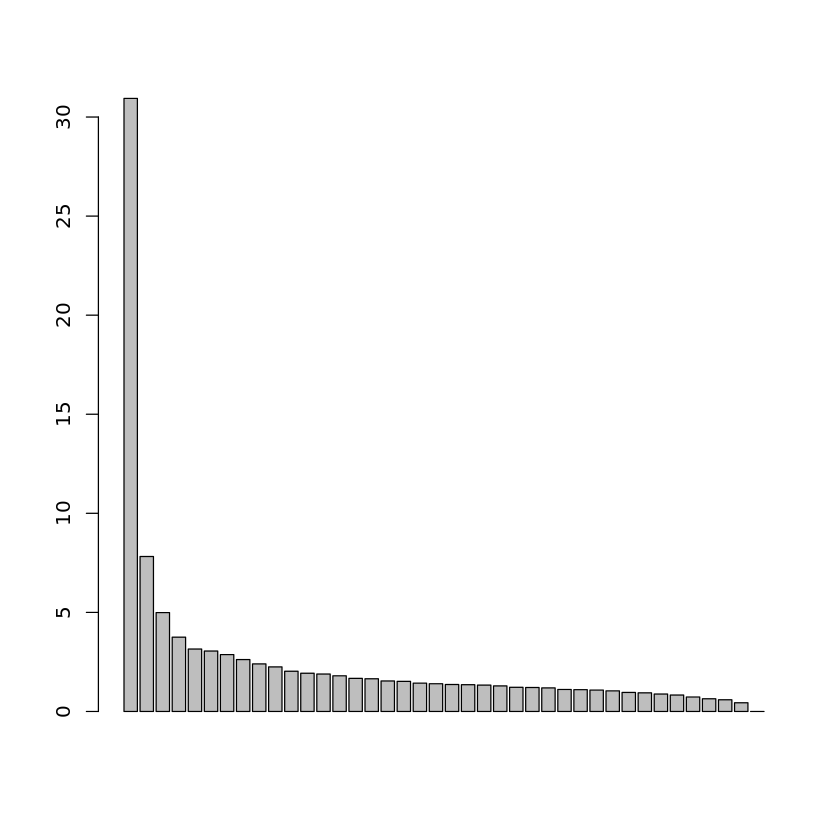

In [23]:
barplot(var_explained)

We can also plot the first few prinicpal components to see if they correlate with any of our experimental variables: 

    * Strain of yeast 
    * Timepoint 
    
We also expect replicates for the same sample to cluster closely together.

Finally, we should make sure to check for any unintended batch effects in the data. For example, it's posssible that samples generated by one researcher may exhibit a systematic difference from samples generated by a different researcher. We should check for this bias and correct it if possible. 


    

In [24]:
#First, we load our metadata file into R to help us color samples by replicate, strain, timepoint, and researcher. 
metadata=read.table("/metadata/TC2019_samples.tsv",header=TRUE)
#We use the "factor" function to tell R which variables are categorical rather than continuous 
metadata$Strain=factor(metadata$Strain)
metadata$Timepoint=factor(metadata$Timepoint)
metadata$Sample=factor(metadata$Sample)
metadata$Researcher=factor(metadata$Researcher)
head(metadata)

Sample,Researcher,Timepoint,Strain,Replicate,ID
<fct>,<fct>,<fct>,<fct>,<int>,<fct>
0min_WT,genegra2,0min,WT,1,genegra2_0min_WT_1
0min_WT,srstern,0min,WT,2,srstern_0min_WT_2
45min_WT,lstrand,45min,WT,1,lstrand_45min_WT_1
45min_WT,ajberg5,45min,WT,2,ajberg5_45min_WT_2
0min_MSN1,sierrasb,0min,MSN1,1,sierrasb_0min_MSN1_1
0min_MSN1,cvduffy,0min,MSN1,2,cvduffy_0min_MSN1_2


In [25]:
#extract the PC columns from the fc.pca object 
pcs=data.frame(fc.pca$x)
head(pcs)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,⋯,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
abalsubr_0min_YAP6_1,-6.983775,-7.671412,-0.7529254,1.7045045,-2.11046757,1.4791023,-1.4105104,0.67111439,-0.3351485,1.28104861,⋯,-0.33776209,-0.42007578,-0.48086733,-0.39123961,0.86196867,-0.04189585,-0.04520782,0.19599831,-0.108529470,-4.697631e-15
abalsubr_45min_HOT1_2,7.091432,2.841598,1.2605998,-0.6528830,-1.72547877,1.6175522,-1.3702243,0.49282369,-1.1435166,2.56425793,⋯,-0.12736446,0.06802913,0.51650091,0.11862110,0.82666412,0.43130714,-0.08887209,-0.24977516,0.266189783,-3.358425e-15
ajberg5_0min_HOG1_1,-5.774118,-5.434964,0.4548626,-1.1059338,-1.55116020,0.9215621,1.5644711,-0.08056343,0.9630229,0.07174876,⋯,-2.33919760,-0.03219645,2.78524632,0.50760822,0.50452677,0.15203389,0.46327552,0.22677291,0.136801440,-5.200701e-15
ajberg5_45min_WT_2,7.353125,2.118293,3.5920411,-1.8670978,-0.81124053,-0.3118369,-0.5488861,-0.56258638,-0.7215134,0.72320401,⋯,0.03822227,-0.52127123,0.40013144,0.22360276,-0.25663040,0.54545686,0.27862327,-0.26279197,0.035206533,-4.636916e-15
annashch_0min_SKO1_2,-7.024351,-2.437984,2.7813155,0.9610299,-0.02268051,1.3981666,-9.9734997,-2.12142832,-1.0784568,-3.19285294,⋯,0.16660626,-0.26930756,0.05078856,-0.03152407,-0.01518200,-0.01473168,0.07153173,-0.02414320,0.167416009,-2.747802e-15
annashch_0min_YAP1_2,-6.077842,6.064219,-0.8759575,2.0432825,3.41982468,-0.9849230,-2.9174483,0.42862631,8.4194639,4.49548231,⋯,-0.10564067,-0.17226034,0.09799694,-0.03554093,0.02234786,0.02619974,0.06721943,-0.07853411,-0.002939897,-4.260481e-15


In [26]:
#add columns from the metadata file. Do this safely using the "merge" command to make sure the sample ID's 
#from the two data frames are aligned
pcs$ID=rownames(pcs)
pcs_annotated=merge(pcs,metadata,by="ID")
head(pcs_annotated)

ID,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,⋯,PC36,PC37,PC38,PC39,PC40,Sample,Researcher,Timepoint,Strain,Replicate
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>,<int>
abalsubr_0min_YAP6_1,-6.983775,-7.671412,-0.7529254,1.7045045,-2.11046757,1.4791023,-1.4105104,0.67111439,-0.3351485,⋯,-0.04189585,-0.04520782,0.19599831,-0.108529470,-4.697631e-15,0min_YAP6,abalsubr,0min,YAP6,1
ajberg5_0min_HOG1_1,-5.774118,-5.434964,0.4548626,-1.1059338,-1.55116020,0.9215621,1.5644711,-0.08056343,0.9630229,⋯,0.15203389,0.46327552,0.22677291,0.136801440,-5.200701e-15,0min_HOG1,ajberg5,0min,HOG1,1
ajberg5_45min_WT_2,7.353125,2.118293,3.5920411,-1.8670978,-0.81124053,-0.3118369,-0.5488861,-0.56258638,-0.7215134,⋯,0.54545686,0.27862327,-0.26279197,0.035206533,-4.636916e-15,45min_WT,ajberg5,45min,WT,2
annashch_0min_YAP1_2,-6.077842,6.064219,-0.8759575,2.0432825,3.41982468,-0.9849230,-2.9174483,0.42862631,8.4194639,⋯,0.02619974,0.06721943,-0.07853411,-0.002939897,-4.260481e-15,0min_YAP1,annashch,0min,YAP1,2
annashch_45min_YAP6_2,4.796370,-3.582421,-3.2453386,1.2093873,0.32910202,0.2796144,-1.4314455,0.19388858,-1.2078302,⋯,-0.66236612,-0.19362790,0.56064495,-0.130840215,-5.670811e-15,45min_YAP6,annashch,45min,YAP6,2
annlin_0min_MSN2_2,-6.268272,2.251502,-2.8332808,0.3535978,0.03262137,0.8929972,-0.4401821,2.54882949,-0.6446475,⋯,-0.57438289,0.20330330,-0.07445921,-0.133446249,-5.462644e-15,0min_MSN2,annlin,0min,MSN2,2


Now, we can use the ggplot package in R to generate scatterplots of PC1 vs PC2, PC2 vs PC3, etc and color-code
by experimental variables. 


In [27]:
library(ggplot2)

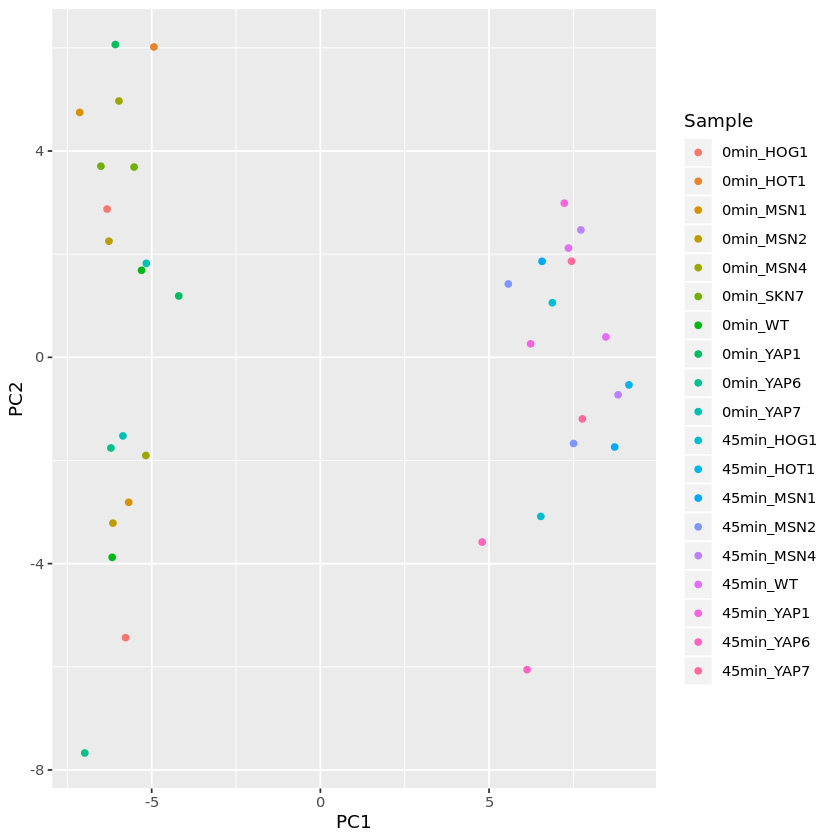

In [28]:
#Plot pc1 vs pc2, color by Sample -- that is, all replicates for the same sample should be the same color. 
ggplot(data=pcs_annotated,aes(x=PC1,y=PC2,color=Sample))+
geom_point()


We should see replicates of the same sample clustering close together. Do we see this in the scatterplot above?

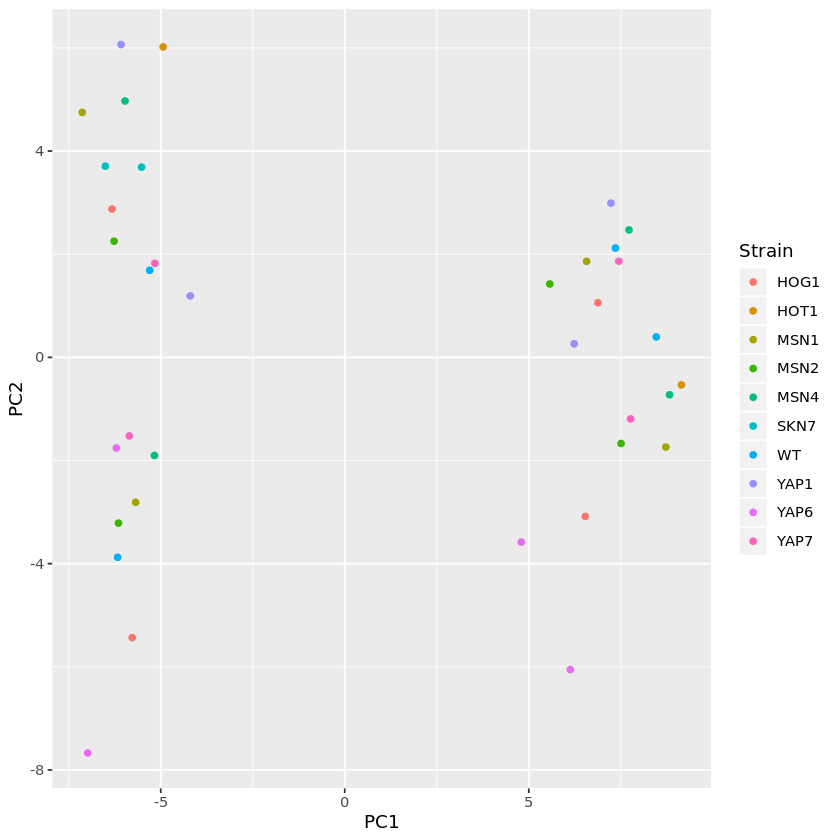

In [29]:
#Plot pc1 vs pc2, color by Strain 
ggplot(data=pcs_annotated,aes(x=PC1,y=PC2,color=Strain))+
geom_point()

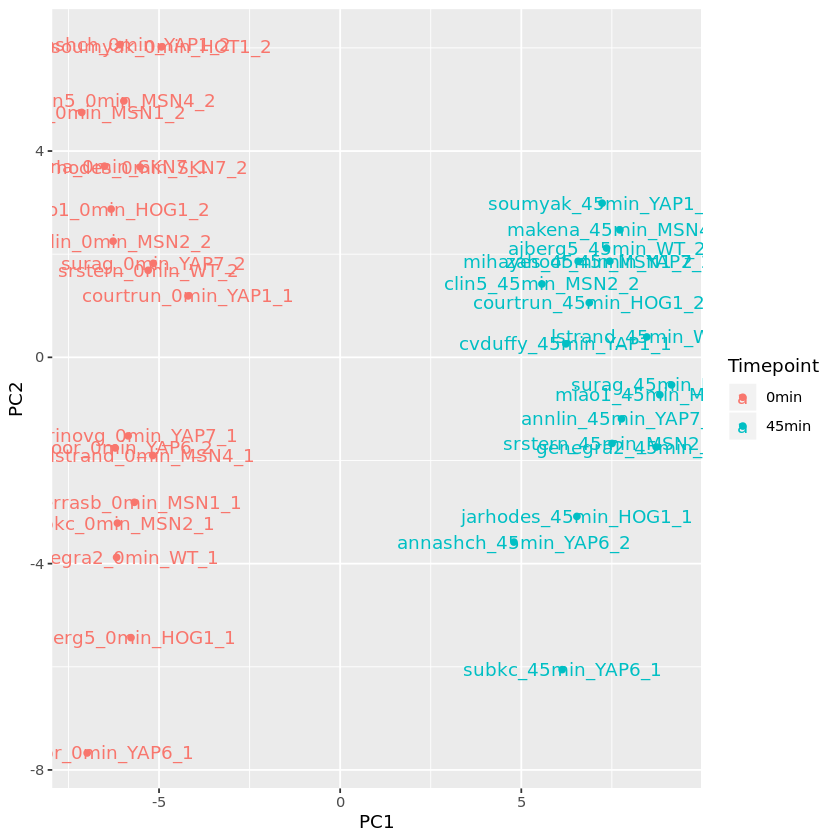

In [30]:
ggplot(data=pcs_annotated,aes(x=PC1,y=PC2,color=Timepoint,label=ID))+
geom_point()+
geom_text()

### Correcting for batch effects ###

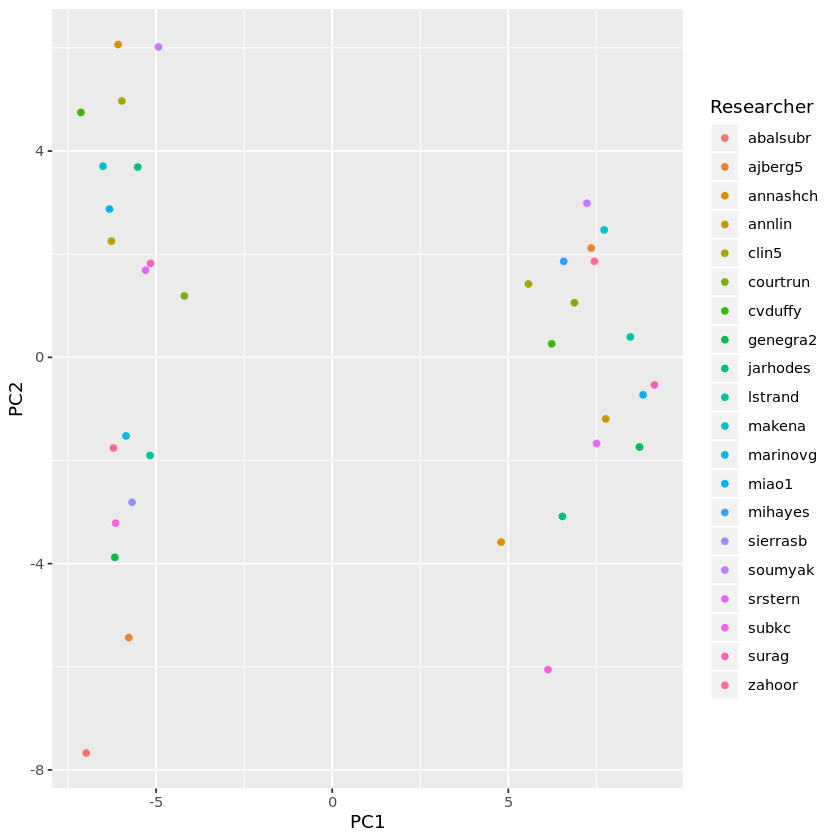

In [31]:
#Plot pc1 vs pc2, color by Researcher -- here, we're checking for a batch effect based on researcher.
ggplot(data=pcs_annotated,aes(x=PC1,y=PC2,color=Researcher))+
geom_point()


There are steps we can take to remove this batch effect. We use the R **limma** package to fit a linear mixed effects model. The explanatory variables are Strain, Timepoint, and Researcher. The output variable is the normalized fold change value in the data matrix. We then subtract out the contribution from "Researcher" (the confounding variable) to the output variable. 

In [32]:
library(limma)

In [33]:
#make sure the row order of the metadata file matches the column order of the fc_data_matrix file. 
rownames(metadata)=metadata$ID
metadata=metadata[colnames(norm_asinh_fc),]


In [38]:
metadata

,Sample,Researcher,Timepoint,Strain,Replicate,ID
,<fct>,<fct>,<fct>,<fct>,<int>,<fct>
abalsubr_0min_YAP6_1,0min_YAP6,abalsubr,0min,YAP6,1,abalsubr_0min_YAP6_1
NA,NA,NA,NA,NA,NA,NA
ajberg5_0min_HOG1_1,0min_HOG1,ajberg5,0min,HOG1,1,ajberg5_0min_HOG1_1
ajberg5_45min_WT_2,45min_WT,ajberg5,45min,WT,2,ajberg5_45min_WT_2
NA.1,NA,NA,NA,NA,NA,NA
annashch_0min_YAP1_2,0min_YAP1,annashch,0min,YAP1,2,annashch_0min_YAP1_2
annashch_45min_YAP6_2,45min_YAP6,annashch,45min,YAP6,2,annashch_45min_YAP6_2
annlin_0min_MSN2_2,0min_MSN2,annlin,0min,MSN2,2,annlin_0min_MSN2_2
annlin_45min_YAP7_1,45min_YAP7,annlin,45min,YAP7,1,annlin_45min_YAP7_1


In [37]:
#design the model using entries from our metadata file 
mod=model.matrix(~0+Strain +Timepoint+Researcher,data=metadata)

#fit the model to the data 
fit=lmFit(norm_asinh_fc,design=mod)

head(coefficients(fit))



ERROR: Error in lmFit(norm_asinh_fc, design = mod): row dimension of design doesn't match column dimension of data object


In [ ]:
#We note that column 5 in the model captures the batch effect from the "Researcher" variable. We can remove the 
#contribution of this variable from the data: 
batch_contribution=coefficients(fit)[,5]%*% t(fit$design[,5])
norm_asinh_fc_corrected=norm_asinh_fc-batch_contribution

Let's re-run the PCA analysis on  fc_data_matrix_corrected to make sure we're no longer observing a batch effect 
due to researcher.



In [ ]:
fc.pca.corrected=prcomp(t(norm_asinh_fc_corrected),center=TRUE,scale=FALSE)
var_explained=round(100*fc.pca.corrected$sdev^2/sum(fc.pca.corrected$sdev^2),2)
barplot(var_explained)
pcs.corrected=data.frame(fc.pca.corrected$x)
pcs.corrected$ID=rownames(pcs.corrected)
pcs_annotated.corrected=merge(pcs.corrected,metadata,by="ID")

In [ ]:
ggplot(data=pcs_annotated.corrected,aes(x=PC1,y=PC2,color=Researcher))+
geom_point()

Excellent! We no longer see the pilot samples clustering together. Let's make sure that the samples still separate by Timepoint. 

In [ ]:
ggplot(data=pcs_annotated.corrected,aes(x=PC1,y=PC2,color=Timepoint))+
geom_point()

Now, we also see a clear separation of the wild type (WT) strain along PC2: 

In [ ]:
ggplot(data=pcs_annotated.corrected,aes(x=PC1,y=PC2,color=Strain))+
geom_point()

In [ ]:
tmp=ebayes(fit)

In [ ]:
length(fit$df.residual)

#### Getting peak contributions to principal components. ####

Finally, we'd like to determine how much each peak contributes to PC1, PC2, and PC3. We can look at PC4 and up also, but for the sake of time we'll stick with the first 3 principal components; from the scree plot, we see they explain approximately 50% of the variance in the data. Primarily we want to get a sense of which peaks are critical in defining the principle components, and in which direction (positive or negative).

In [ ]:
contribs_pc1=sort(fc.pca.corrected$rotation[,1])
contribs_pc2=sort(fc.pca.corrected$rotation[,2])
contribs_pc3=sort(fc.pca.corrected$rotation[,3])

#these are lists of contributs from each peak to the corresponding PC
tail(contribs_pc1)
length(contribs_pc1)

In [ ]:
#Use the write.table command to write the PC contribution data to output files. 

write.table(contribs_pc1,paste(work_dir,"pc1_contribs.txt",sep='/'),quote=FALSE,col.names=FALSE,row.names=TRUE,sep='\t')
write.table(contribs_pc2,paste(work_dir,"pc2_contribs.txt",sep='/'),quote=FALSE,col.names=FALSE,row.names=TRUE,sep='\t')
write.table(contribs_pc3,paste(work_dir,"pc3_contribs.txt",sep='/'),quote=FALSE,col.names=FALSE,row.names=TRUE,sep='\t')


## Hierarchical Clustering of Fold Change Signal Across Samples ##

Cluster analysis is a simple way to visualize patterns in the data. By clustering peaks according to their signal across different time points, we may find groups of peaks that have similar behavior across these time points. By clustering samples according to their signal across peaks, we can perform a simple sanity check of data quality ‐ samples of the same time point should cluster together.

In [ ]:
library(gplots)
library(RColorBrewer)

In [ ]:
?dist

In [ ]:
?hclust

Let's begin by clustering normalized fold change data that has not been corrected for the sample swap or the batch effect:

In [ ]:
heatmap.2(norm_asinh_fc,
          scale     = "none",
          col       = rev(colorRampPalette(brewer.pal(10, "RdBu"))(256)),
          distfun   = function(x) dist(x,method="euclidean"),
          hclustfun = function(x) hclust(x, method="ward.D"),
          Rowv=TRUE,
          Colv=TRUE,
          trace="none",
          cexCol = 0.9,
          margins=c(15,5),
          labRow="")



Now, we examine the hierarchical clustering on the corrected fold change data. 

In [ ]:
heatmap.2(norm_asinh_fc_corrected,
          scale     = "none",
          col       = rev(colorRampPalette(brewer.pal(10, "RdBu"))(256)),
          distfun   = function(x) dist(x,method="euclidean"),
          hclustfun = function(x) hclust(x, method="ward.D"),
          Rowv=TRUE,
          Colv=TRUE,
          trace="none",
          cexCol = 0.9,
          margins=c(15,5),
          labRow="")


There is very little contrast in the heatmap that was generated. We can add contrast by modifying how "breaks" between colors are generated. 

In [ ]:
#We split the fold change matrix into 1% quantiles 
quantile.range <- quantile(norm_asinh_fc_corrected, probs = seq(0, 1, 0.01))
#we scale the breaks in the heatmap color palette according to the quantiles. 
palette.breaks <- seq(quantile.range["5%"], quantile.range["95%"], 0.1)


heatmap.2(norm_asinh_fc_corrected,
          scale     = "none",
          col       = rev(colorRampPalette(brewer.pal(10, "RdBu"))(length(palette.breaks) - 1)),
          distfun   = function(x) dist(x,method="euclidean"),
          hclustfun = function(x) hclust(x, method="ward.D"),
          Rowv=TRUE,
          Colv=TRUE,
          trace="none",
          cexCol = 0.9,
          margins=c(15,5),
          breaks = palette.breaks,
          labRow="")


The two heatmaps look very different, but show the same data! 
When selecting a color scheme for PCA or heatmaps in R, the R Color Brewer tool is quite useful. Also, for nice color palettes, check out: http://colorbrewer2.org/#type=sequential&scheme=BuGn&n=3